softmax回归的从零开始实现
就像我们从零开始实现线性回归一样， 你应该知道实现softmax的细节

In [1]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [18]:

print("CUDA 是否可用:", torch.cuda.is_available())
print("GPU 数量:", torch.cuda.device_count())
print("当前 GPU 名称:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "无")


CUDA 是否可用: True
GPU 数量: 1
当前 GPU 名称: NVIDIA GeForce MX550


In [2]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [3]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [4]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

实现softmax

$softmax(X)ij=\frac{exp(Xij)}{∑kexp(Xik)}$.

In [5]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1170, 0.4574, 0.1517, 0.1306, 0.1433],
         [0.1964, 0.1283, 0.1698, 0.2278, 0.2778]]),
 tensor([1., 1.]))

In [6]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [7]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [8]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [9]:
def accuracy(y_hat, y):
    """计算预测正确的数量。"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

In [10]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [11]:
class Accumulator:
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

evaluate_accuracy(net, test_iter)

0.0113

In [12]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）。"""
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat, y),
                y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [13]:
class Animator:
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [14]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [15]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [16]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

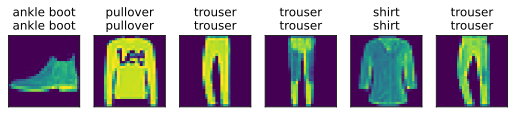

In [17]:
def predict_ch3(net, test_iter, n=6):
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)